# 2. Clustering  
To solve this task, you must:  
1.Implement the k-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class.  
2.Run the algorithm on the food data. Then, use the already implemented version of k-means++, are there any differences in results?  
3.Analyse the obtained clusters:  
*Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a visualization called word cloud.  
*Provide the number of product in each cluster  
*Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!  
*Get the number of unique users writing reviews in each cluster  

## 2.1 Define the K-Means Algorithm

### 2.1.1 import modules

In [43]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer 

### 2.1.2 Read Data

In [3]:
dataset = pd.read_csv('Reviews.csv')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### 2.1.3 Data Clean-Up

In [5]:
dataset.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
dataset['ProfileName'].fillna('',inplace=True)
dataset['Summary'].fillna('',inplace=True)

In [7]:
dataset.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [8]:
dataset.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
dataset.iloc[0].Time

1303862400

In [10]:
pd.to_datetime(dataset.iloc[0].Time,unit='s')

Timestamp('2011-04-27 00:00:00')

In [11]:
dataset['Datetime'] = dataset.Time.apply(lambda value:pd.to_datetime(value,unit='s'))

### 2.1.4 Extract features

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [13]:
lemmatizer = WordNetLemmatizer()
stop_words=set(stopwords.words('english'))

In [14]:
def clean_text(text):
    words = word_tokenize(text)    
    filtered_words = []
    for word in words:        
        if word.lower() not in stop_words and word.isalpha():
            filtered_words.append(lemmatizer.lemmatize(word.lower()))
    return filtered_words

In [15]:
dataset['Summary'] = dataset['Summary'].apply(lambda text:clean_text(text))

In [16]:
dataset['Text'] = dataset['Text'].apply(lambda text:clean_text(text))

In [17]:
df=dataset[['ProductId','Summary','Text']]

In [18]:
df.head(5)

,ProductId,Summary,Text
0,B001E4KFG0,"[good, quality, dog, food]","[bought, several, vitality, canned, dog, food,..."
1,B00813GRG4,[advertised],"[product, arrived, labeled, jumbo, salted, pea..."
2,B000LQOCH0,"[delight, say]","[confection, around, century, light, pillowy, ..."
3,B000UA0QIQ,"[cough, medicine]","[looking, secret, ingredient, robitussin, beli..."
4,B006K2ZZ7K,"[great, taffy]","[great, taffy, great, price, wide, assortment,..."


In [19]:
type(df)

pandas.core.frame.DataFrame

In [20]:
words=[] 
all_words = [] 
for i in range(len(df)):
    c_all = []
    for wordt in df['Summary'][i]:
        words.append(wordt)
        c_all.append(wordt)
    for wordp in df['Text'][i]:
        words.append(wordp)
        c_all.append(wordp)
    all_words.append(c_all)
df["Discription"] = pd.Series(all_words)
df.head(5) 

<ipython-input-20-684dc4e01a49>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Discription"] = pd.Series(all_words)


,ProductId,Summary,Text,Discription
0,B001E4KFG0,"[good, quality, dog, food]","[bought, several, vitality, canned, dog, food,...","[good, quality, dog, food, bought, several, vi..."
1,B00813GRG4,[advertised],"[product, arrived, labeled, jumbo, salted, pea...","[advertised, product, arrived, labeled, jumbo,..."
2,B000LQOCH0,"[delight, say]","[confection, around, century, light, pillowy, ...","[delight, say, confection, around, century, li..."
3,B000UA0QIQ,"[cough, medicine]","[looking, secret, ingredient, robitussin, beli...","[cough, medicine, looking, secret, ingredient,..."
4,B006K2ZZ7K,"[great, taffy]","[great, taffy, great, price, wide, assortment,...","[great, taffy, great, taffy, great, price, wid..."


In [21]:
dfn = df[['ProductId','Discription']]

In [22]:
dfn.head()

,ProductId,Discription
0,B001E4KFG0,"[good, quality, dog, food, bought, several, vi..."
1,B00813GRG4,"[advertised, product, arrived, labeled, jumbo,..."
2,B000LQOCH0,"[delight, say, confection, around, century, li..."
3,B000UA0QIQ,"[cough, medicine, looking, secret, ingredient,..."
4,B006K2ZZ7K,"[great, taffy, great, taffy, great, price, wid..."


In [23]:
dfn = dfn['Discription'].agg(lambda x: ' '.join(x)).reset_index()

In [24]:
dfn

,index,Discription
0,0,good quality dog food bought several vitality ...
1,1,advertised product arrived labeled jumbo salte...
2,2,delight say confection around century light pi...
3,3,cough medicine looking secret ingredient robit...
4,4,great taffy great taffy great price wide assor...
...,...,...
568449,568449,without great sesame chicken good better restu...
568450,568450,disappointed disappointed flavor chocolate not...
568451,568451,perfect maltipoo star small give one training ...
568452,568452,favorite training reward treat best treat trai...


### 2.1.5 Skicit-learn K-means++

In [ ]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(dfn['Discription']))

#### reduce the dimensionality of the dataset's feature
 * a number of components that retain> 60% of the variance 

100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [1:59:56<00:00, 514.00s/it]


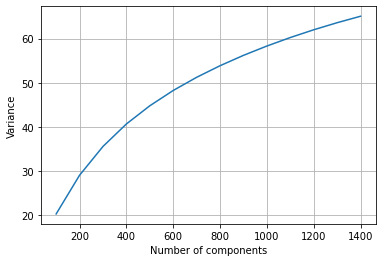

In [45]:
components= {}
for num in tqdm(range(100, 1500, 100)):
    svd = TruncatedSVD(n_components=num)
    svd.fit_transform(tfidf)
    components[num] = round(np.cumsum(svd.explained_variance_ratio_)[-1], 5) * 100
    del svd
plt.plot(list(components.keys()), list(components.values()))
plt.xlabel('Number of components')
plt.ylabel('Variance')
plt.grid()
plt.show()

In [46]:

svd = TruncatedSVD(n_components=1200)
normalizer = Normalizer(copy=False)
mp = make_pipeline(svd, normalizer)
reduced = mp.fit_transform(tfidf)

In [47]:
reduced

array([[ 0.26324182, -0.19594496, -0.04716568, ..., -0.01823233,
         0.04219661,  0.00635989],
       [ 0.091213  , -0.04244946, -0.00880783, ...,  0.03207198,
        -0.01137357, -0.02939239],
       [ 0.09773761, -0.05135853, -0.00896363, ..., -0.0049308 ,
         0.01373345,  0.03091342],
       ...,
       [ 0.26512699, -0.24435019, -0.05682201, ...,  0.01604051,
         0.02175232, -0.00195463],
       [ 0.1459005 , -0.12289729, -0.03295071, ...,  0.00425589,
        -0.00206819,  0.00847014],
       [ 0.09542786, -0.0117031 ,  0.00438408, ...,  0.00450961,
         0.02989111, -0.03254712]])

In [48]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(reduced)

KMeans(n_clusters=20)

## 2.2 Run the algorithm on the food data and compared with K-Means++

In [163]:
class K_Means(object):
    def __init__(self, k=20, tolerance=0.0001, max_iter=300):
        self.k_ = k
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter

    def fit(self, data):
        self.centers_ = {}
        for i in range(self.k_):
            self.centers_[i] = data[i]

        for i in range(self.max_iter_):
            self.clf_ = {}
            for i in range(self.k_):
                self.clf_[i] = []
            
            for feature in data:
                # distances = [np.linalg.norm(feature-self.centers[center]) for center in self.centers]
                distances = []
                for center in self.centers_:
                    
                    # np.sqrt(np.sum((features-self.centers_[center])**2))
                    distances.append(np.linalg.norm(feature - self.centers_[center]))
                classification = distances.index(min(distances))
                self.clf_[classification].append(feature)

            prev_centers = dict(self.centers_)
            for c in self.clf_:
                self.centers_[c] = np.average(self.clf_[c], axis=0)

            
            optimized = True
            for center in self.centers_:
                org_centers = prev_centers[center]
                cur_centers = self.centers_[center]
                if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:
                    optimized = False
            if optimized:
                break
    def predict(self, p_data):
        distances = [np.linalg.norm(p_data - self.centers_[center]) for center in self.centers_]
        index = distances.index(min(distances))
        return index

In [158]:
 K_Means(reduced)

In [152]:
k_means = K_Means(k=20)
k_means.fit(reduced)
print(k_means.centers_)

{0: array([ 1.89535687e-01,  4.29321186e-04, -1.10590780e-03, ...,
        6.55047586e-05,  6.70539972e-04,  1.99012205e-04]), 1: array([ 1.66558900e-01, -1.40911111e-02, -4.21104117e-03, ...,
        5.00154715e-04, -1.07429975e-04, -1.34242378e-04]), 2: array([ 1.67171100e-01, -7.32449022e-03, -5.00874414e-03, ...,
        1.25030570e-04,  7.36790970e-04,  5.49111360e-04]), 3: array([ 1.68128237e-01,  2.29480120e-02,  9.91661722e-03, ...,
        1.43832992e-04, -2.31836615e-04,  4.01236087e-04]), 4: array([ 0.18097159,  0.06850494, -0.00923065, ...,  0.00092038,
       -0.00058251, -0.00087997]), 5: array([ 1.70082968e-01,  4.66097642e-02,  1.42520352e-02, ...,
        1.40445579e-04, -1.22467965e-03,  2.48747963e-04]), 6: array([ 1.68786375e-01,  3.25827992e-02,  4.91979856e-03, ...,
        8.82955691e-05,  4.68078569e-04, -3.15609545e-04]), 7: array([ 1.73682915e-01,  4.45444872e-02,  7.84485363e-03, ...,
        5.02831712e-04, -5.41117441e-04,  3.24837755e-05]), 8: array([ 1.67

In [170]:
R=[]
for item in reduced:
    R.append(k_means.predict(item))

In [ ]:
for item in R:
    print(R)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



> Now, compare the K-Means and K-Means++, we can see that they have different center centroids and different results.

In [37]:
from tqdm import tqdm
elbow = {}
for k in tqdm(range(3, 30)):
    elbow_model = KMeans(n_clusters=k)
    elbow_model.fit_predict(reduced) 
    elbow[k] = elbow_model.inertia_

100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [2:17:04<00:00, 304.60s/it]


In [39]:
elbow

{3: 523782.23821093363,
 4: 515601.8865995705,
 5: 509317.21157757886,
 6: 504847.77008642786,
 7: 502180.29271234927,
 8: 499383.2733348218,
 9: 497303.7955360554,
 10: 495159.11225372826,
 11: 493701.81735294446,
 12: 491942.29705467034,
 13: 490530.34395505255,
 14: 489271.70575439977,
 15: 487700.4670659921,
 16: 486312.159181196,
 17: 485161.02515386033,
 18: 483738.3029104983,
 19: 482317.4989349685,
 20: 480899.6244104503,
 21: 479968.8811989788,
 22: 478718.8423092544,
 23: 477200.7587757586,
 24: 475947.10034610744,
 25: 474874.37236074,
 26: 473897.54156298534,
 27: 473134.780208335,
 28: 472181.2194112361,
 29: 471247.48870262585}

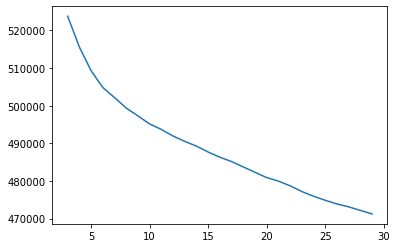

In [40]:
plt.plot(list(elbow.keys()),list(elbow.values()))

## 2.3 Analyse the obtained clusters:

### 2.3.1 Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a visualization called word cloud.

In [112]:
dataset['Description']=dfn['Discription']

In [113]:
dataset

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime,cluster,Description
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,"[good, quality, dog, food]","[bought, several, vitality, canned, dog, food,...",2011-04-27,14,good quality dog food bought several vitality ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,[advertised],"[product, arrived, labeled, jumbo, salted, pea...",2012-09-07,13,advertised product arrived labeled jumbo salte...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"[delight, say]","[confection, around, century, light, pillowy, ...",2008-08-18,3,delight say confection around century light pi...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,"[cough, medicine]","[looking, secret, ingredient, robitussin, beli...",2011-06-13,8,cough medicine looking secret ingredient robit...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,"[great, taffy]","[great, taffy, great, price, wide, assortment,...",2012-10-21,3,great taffy great taffy great price wide assor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,[without],"[great, sesame, chicken, good, better, restura...",2011-03-09,3,without great sesame chicken good better restu...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,[disappointed],"[disappointed, flavor, chocolate, note, especi...",2012-03-09,8,disappointed disappointed flavor chocolate not...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,"[perfect, maltipoo]","[star, small, give, one, training, session, tr...",2012-02-21,14,perfect maltipoo star small give one training ...
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,"[favorite, training, reward, treat]","[best, treat, training, rewarding, dog, good, ...",2012-03-13,10,favorite training reward treat best treat trai...


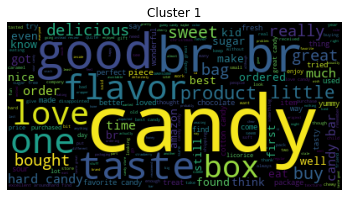

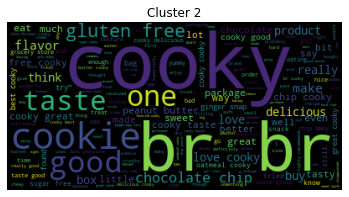

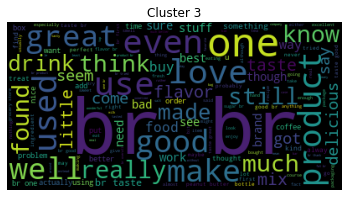

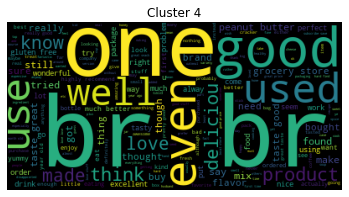

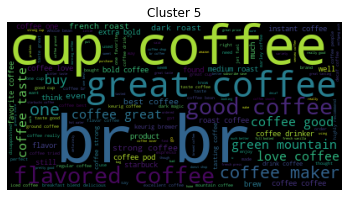

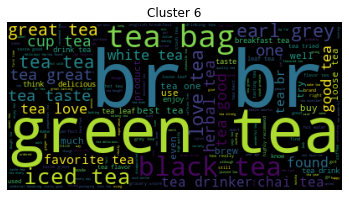

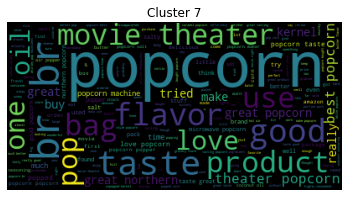

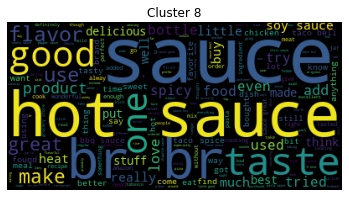

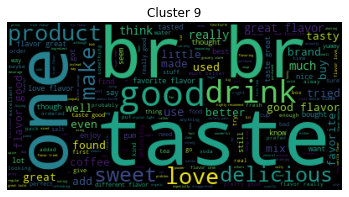

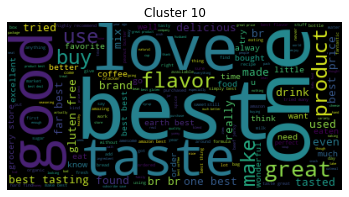

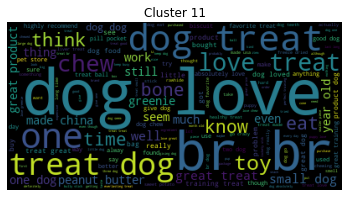

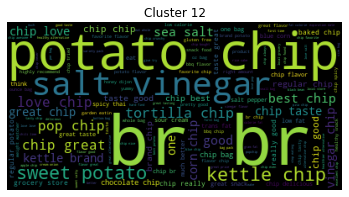

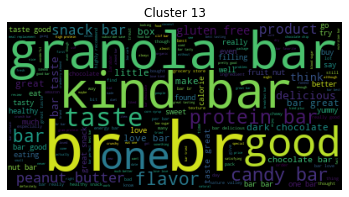

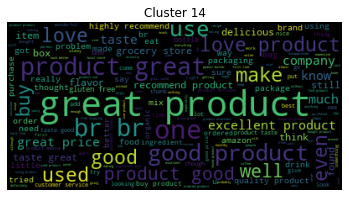

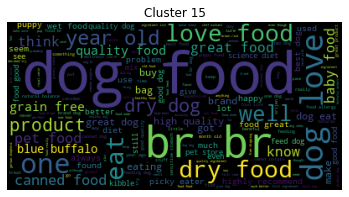

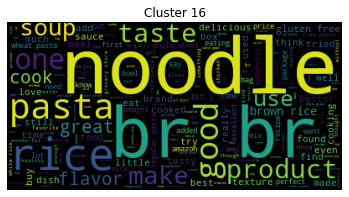

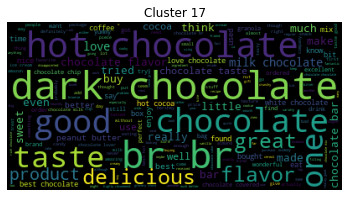

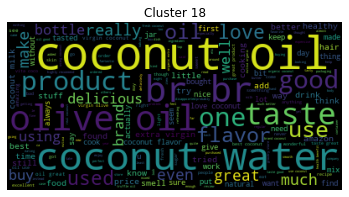

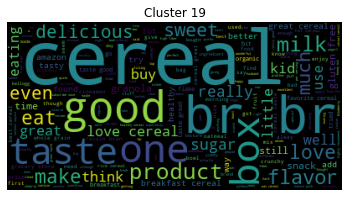

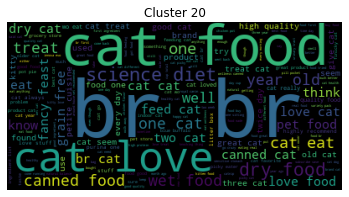

In [118]:
from wordcloud import WordCloud
for i in range(20):
    wl_space_split = " ".join(dataset[dataset.cluster==i].Description)
    my_wordcloud = WordCloud().generate(wl_space_split)
    plt.imshow(my_wordcloud)
    plt.title(f'Cluster {i+1}')
    plt.axis("off")
    plt.show()

### 2.3.2 Provide the number of product in each cluster

In [55]:
cluster = kmeans.predict(reduced)

In [56]:
dataset['cluster']=cluster

In [57]:
products_per_cluster={}
for cluster in range(0,20):
    products_per_cluster[cluster]=len(
        dataset[dataset.cluster==cluster].ProductId.unique())

In [58]:
products_per_cluster

{0: 4077,
 1: 2146,
 2: 19615,
 3: 42104,
 4: 4902,
 5: 5982,
 6: 654,
 7: 3233,
 8: 14465,
 9: 12507,
 10: 3849,
 11: 1349,
 12: 1702,
 13: 19643,
 14: 2953,
 15: 2951,
 16: 4306,
 17: 1960,
 18: 1562,
 19: 2217}

### 2.3.3 Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!

In [101]:
score_distribution={}
for cluster in range(0,20):
    score_distribution[cluster]=dataset[dataset.cluster==cluster].groupby(dataset.Score).Id.count()

<AxesSubplot:ylabel='Score'>

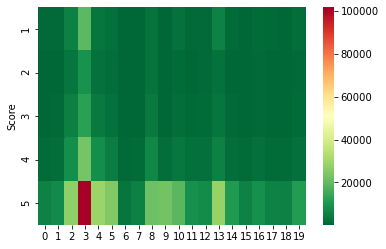

In [102]:
import seaborn as sns
sns.heatmap(pd.DataFrame(score_distribution),cmap='RdYlGn_r')

In [131]:
score_per_cluster={}
for cluster in range(0,20):
    score_per_cluster[cluster]=dataset[
        dataset.cluster==cluster].Score.mean()

In [132]:
score_per_cluster

{0: 4.223468803663423,
 1: 4.283146264468607,
 2: 3.9866756723566255,
 3: 4.07087607196906,
 4: 4.200784396862413,
 5: 4.364482615320681,
 6: 4.268120212139069,
 7: 4.3776312452447375,
 8: 4.0915321115206895,
 9: 4.791025944326157,
 10: 4.276477264666241,
 11: 4.3128036475072875,
 12: 4.286232741617357,
 13: 4.046257544385215,
 14: 4.311808707883127,
 15: 4.353225443919982,
 16: 4.212453156529259,
 17: 4.215451215451216,
 18: 4.343229543808834,
 19: 4.217022738988487}

### 2.3.4 Get the number of unique users writing reviews in each cluster 

In [76]:
user_per_cluster={}
for cluster in range(0,20):
    user_per_cluster[cluster]=len(dataset[dataset.cluster==cluster].UserId.unique())

In [77]:
user_per_cluster

{0: 7315,
 1: 5835,
 2: 23697,
 3: 99862,
 4: 22692,
 5: 19424,
 6: 2867,
 7: 6327,
 8: 21750,
 9: 18271,
 10: 11723,
 11: 3638,
 12: 6385,
 13: 31247,
 14: 6801,
 15: 7366,
 16: 9290,
 17: 6383,
 18: 6098,
 19: 6900}

# 3. Algorithmic question
You are given an array with A with n integer numbers.

Let s = min{ A[1], ..., A[n] } and b = max { A[1], ..., A[n] }.  
Let r = b - s  
Prove that we can sort A in time O(n + r).  

In [ ]:
def countingSort(arr, maxValue):
    bucketLen = maxValue+1
    bucket = [0]*bucketLen
    sortedIndex =0
    arrLen = len(arr)
    for i in range(arrLen):
        if not bucket[arr[i]]:
            bucket[arr[i]]=0
        bucket[arr[i]]+=1
    for j in range(bucketLen):
        while bucket[j]>0:
            arr[sortedIndex] = j
            sortedIndex+=1
            bucket[j]-=1
    return arr

In [ ]:
countingSort([1,3,2,5,8,9,6,7], 9)

> Counting-Sort pesudo code:  
countingSort(array, size)  
  max <- find largest element in array  
  initialize count array with all zeros  
  for j <- 0 to size  
    find the total count of each unique element and  store the count at jth index in count array  
  for i <- 1 to max  
    find the cumulative sum and store it in count array itself  
  for j <- size down to 1  
    restore the elements to array  
decrease count of each element restored by 1  


As we can see the pseudo code of Counting Sort method, we can see that:
Overall complexity = O(max)+O(size)+O(max)+O(size) = O(max+size)=O(b+n).
So if the minimum s equal to 0, wen can sort A in time O(n+b-s) = O(n+r).  
And if the minimum is not 0, such as bigger than 0 or smaller than 0, we can change the array's minimum to 0 by minusing or adding a value.

